In [35]:
#Setting up path in Intel Dev Cloud
%env PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support
import os
import sys


sys.path.insert(0, os.path.abspath('/opt/intel_devcloud_support'))
sys.path.insert(0, os.path.abspath('/opt/intel'))

env: PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support


Testing on <a href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI* TANK AIOT DEVELOPER KIT</a>

List of devices available to test are available <a href="https://devcloud.intel.com/edge/get_started/devcloud/">here</a>


In [57]:
#Creating a function to submit job
model_path = '/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013'
video_path = '/data/resources/transportation.mp4'
queue_param = '/data/queue_param/transportation.npy'
Max_people = 4

def submit_job(device,node_name):
    device_name = device
    if device_name.startswith('HETERO:FPGA'):
        device_name = 'FPGA'
        
    
    Output_path = '/output/results/transportation/'+ device_name
    flag = '{} {} {} {} {} {}'.format(model_path,device,video_path,queue_param,Output_path,Max_people)
    
    job_name = "Transportation"+device_name
    
    job_ID = !qsub queue_job.sh -l nodes=1:{node_name} -d . -F "{flag}" -N job_name

    return job_ID


<h2>1. Submitting a job to run on CPU - 
<a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE Processor</a></h2>

In [58]:
CPU_job_ID = submit_job('CPU', 'tank-870:i5-6500te')
print("CPU: ",CPU_job_ID)

CPU:  ['5oxCC4hC0wVZ92Z0ZsdwUI0G0l0Z82zB']


In [59]:
import liveQStat
import get_results
import videoHtml

In [39]:
#Checking Job status
liveQStat.liveQStat()

In [60]:
#retrieving job result
get_results.getResults(CPU_job_ID[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:5oxCC4hC0wVZ92Z0ZsdwUI0G0l0Z82zB) are ready.
Please wait..........................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [61]:
#Unpacking output files 

!tar zxf output.tgz



In [62]:
#Viewing error log
!cat stderr.log

person_detect.py:50: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  self.model=IENetwork(self.model_structure, self.model_weights)


In [ ]:
#Viewing output video

videoHtml.videoHTML('transportation CPU', ['results/transportation/CPU/output_video.mp4'])

<h2>2. Submitting a job to run on Integrated GPU - 
<a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® HD Graphics 530</a></h2>

In [64]:
job_ID = submit_job('GPU', 'tank-870:i5-6500te:intel-hd-530')
print("GPU: ",job_ID)

#retrieving job result
get_results.getResults(job_ID[0], filename='output.tgz', blocking=True)

#Unpacking output files and viewing stdout.log
!tar zxf output.tgz

GPU:  ['R5fvB2y7VEJJRTA0ogIOrEDeTE5yZ70s']
getResults() is blocking until results of the job (id:R5fvB2y7VEJJRTA0ogIOrEDeTE5yZ70s) are ready.
Please wait...............................................................................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [ ]:
#Viewing output video

videoHtml.videoHTML('transportation GPU', ['results/transportation/GPU/output_video.mp4'])

<h2>3. Submitting a job to run on VPU - <a href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a></h2>

In [66]:
job_ID = submit_job('MYRIAD', 'tank-870:i5-6500te:intel-ncs2')
print("VPU: ",job_ID)

#retrieving job result
get_results.getResults(job_ID[0], filename='output.tgz', blocking=True)

#Unpacking output files and viewing stdout.log
!tar zxf output.tgz

VPU:  ['3D2wMKAcHfJQM53bArGuwX9uhjZ9j804']
getResults() is blocking until results of the job (id:3D2wMKAcHfJQM53bArGuwX9uhjZ9j804) are ready.
Please wait.......................................................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [ ]:
#Viewing output video

videoHtml.videoHTML('transportation VPU', ['results/transportation/MYRIAD/output_video.mp4'])

<h2>4. Submitting a job to run on FPGA - <a href="https://www.ieiworld.com/mustang-f100/en/">IEI Mustang-F100-A10 </a></h2>

In [68]:
job_ID = submit_job('HETERO:FPGA,CPU', 'tank-870:i5-6500te:iei-mustang-f100-a10')
print("FPGA: ",job_ID)

#retrieving job result
get_results.getResults(job_ID[0], filename='output.tgz', blocking=True)

#Unpacking output files and viewing stdout.log
!tar zxf output.tgz

FPGA:  ['K2sabnBWGjeHKdJeFuVRrcRTuq7gefN0']
getResults() is blocking until results of the job (id:K2sabnBWGjeHKdJeFuVRrcRTuq7gefN0) are ready.
Please wait...............................................................................................................................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [ ]:
#Viewing output video

videoHtml.videoHTML('transportation FPGA', ['results/transportation/FPGA/output_video.mp4'])

# Assess Performance

In [70]:
import matplotlib.pyplot as plt

device_list=['CPU', 'GPU', 'FPGA', 'MYRIAD']
inference_time=[]
fps=[]
model_load_time=[]

for device in device_list:
    with open('results/transportation/'+device+'/stats.txt', 'r') as f:
        inference_time.append(float(f.readline().split("\n")[0]))
        fps.append(float(f.readline().split("\n")[0]))
        model_load_time.append(float(f.readline().split("\n")[0]))
        


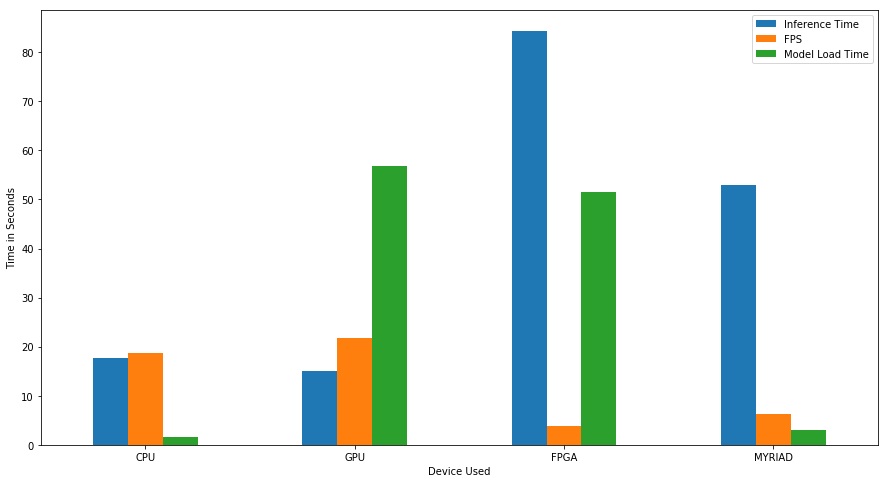

In [71]:
import pandas as pd

plt.rc('figure', figsize=(15, 8))
index = device_list
df = pd.DataFrame({'Inference Time': inference_time,
                   'FPS': fps,
                   'Model Load Time': model_load_time}, index=index)
ax = df.plot.bar(rot=0)


plt.xlabel("Device Used")
plt.ylabel("Time in Seconds")
plt.show()

In [72]:
df

,Inference Time,FPS,Model Load Time
CPU,17.7,18.644068,1.606816
GPU,15.1,21.854305,56.791703
FPGA,84.4,3.909953,51.415828
MYRIAD,53.0,6.226415,2.936996


In [ ]:
#viewing stdout.log

!cat stdout.log
